In [360]:
import numpy as np
from csaps import csaps
from scipy.interpolate import CubicSpline
import scipy.integrate as integrate
import matplotlib.pyplot as plt

%matplotlib inline

In [402]:
# load data

ind =57
name='F_{}_P_0_to_160000.npy'.format(ind)
path='/home/jovyan/work/sv_data/'

data=np.load(path+name,allow_pickle=True)
path1 = data[157731]

In [403]:
class build_real_track:
    
    def __init__(self,W,kap_max,F,Len):
        F1=F[0]
        F2=F[1]
        self.W = W
        self.kap_max = kap_max
        self.F = F
        self.Len = Len
        
        PX=[0,F2,1]
        PY=[0,kap_max,0]
        kap_intp = CubicSpline(PX,PY,bc_type=((1,0),(1,0)))
        xx=np.linspace(0,1,100)
        yy=kap_intp(xx)
        
        psi=integrate.cumtrapz(yy,xx*Len, initial=0)
    
        X = integrate.cumtrapz(np.cos(psi), xx*Len, initial=0)
        Y = integrate.cumtrapz(np.sin(psi), xx*Len, initial=0)
        [X_Left,Y_Left] = self.bias(X,Y,psi,W)
        [X_Right,Y_Right] = self.bias(X,Y,psi,-W)
        
        X_negative = np.linspace(-F1 * Len,0,100)
        X_positive = np.linspace(0, F1*Len, 100)
        Y_negative = np.zeros(100)
        
        
        self.S = np.hstack((X_positive[:-1], xx * Len +X_positive[-1]))
        self.Center_X = np.hstack((X_negative[:-1],X))
        self.Center_Y = np.hstack((Y_negative[:-1],Y))
        self.Left_X = np.hstack((X_negative[:-1],X_Left))
        self.Left_Y = np.hstack((Y_negative[:-1]+W,Y_Left))
        self.Right_X = np.hstack((X_negative[:-1],X_Right))
        self.Right_Y = np.hstack((Y_negative[:-1]-W,Y_Right))
        self.psi = np.hstack((Y_negative[:-1],psi))
#         self.plot()
        
    def bias(self,X,Y,psi,W):
        X2 = X - W * np.sin(psi)
        Y2 = Y + W * np.cos(psi)
        
        return X2,Y2
        
    def plot(self):
        plt.figure()
        plt.plot(self.Center_X,self.Center_Y,'k')
        plt.plot(self.Left_X,self.Left_Y,'b--')
        plt.plot(self.Right_X,self.Right_Y,'r--')
        
        plt.axis('equal')
        plt.show()
    
    

In [412]:
class build_real_path:
    
    def retrive_standard_path(self,F,P,path):
        F1=F[0]
        F2=F[1]
        
        self.S_std = np.linspace(0,1+F1,path.shape[0])
        self.X_std = np.linspace(-F1,1,path.shape[0])
        self.Y_std = path
    
    def retrive_real_path(self,T):
        self.T = T  
        s_extend = self.S_std * T.Len
        Y_extend = self.Y_std * T.W * 10
        
        T_X_intp = CubicSpline(T.S,T.Center_X)
        T_Y_intp = CubicSpline(T.S,T.Center_Y)
        T_psi_intp = CubicSpline(T.S,T.psi)
        
        T_X = T_X_intp(s_extend)
        T_Y = T_Y_intp(s_extend)
        T_psi = T_psi_intp(s_extend)
        
        [self.X, self.Y] = self.bias(T_X,T_Y,T_psi,Y_extend)
        self.Center_S = s_extend
        

    def bias(self,X,Y,psi,W):
        X2 = X - W * np.sin(psi)
        Y2 = Y + W * np.cos(psi)
        return X2,Y2
        
    def get_kap(self):
        arr = np.linspace(0,self.X.shape[0],self.X.shape[0])
        X_intp = CubicSpline(arr,self.X)
        Y_intp = CubicSpline(arr,self.Y)
        
        X = X_intp(arr)
        Y = Y_intp(arr)
        dX = X_intp(arr,1)
        dY = Y_intp(arr,1)
        d2X = X_intp(arr,2)
        d2Y = Y_intp(arr,2)
        
        self.ds = np.sqrt(dX**2+dY**2)
        self.psi = np.arctan2(dY,dX)
        self.kap = (dX*d2Y-dY*d2X)/(dX**2+dY**2)**1.5
        
        self.S = integrate.cumtrapz(self.ds,initial=0)
    
    def get_velocity(self, V_init, ay_max, ax_max, ax_min):
        
        kap = np.abs(self.kap) + 1.0e-10
        ds = self.ds
        num = kap.shape[0]
        V0 = np.ones(num) * 1.0
        V1 = np.empty(num)
        V2 = np.empty(num)
        
        
        threshold = 0.01
        flag = 1
        t0 = 0
        
        
        while flag ==1:
        
            # rest of ay
            ay_rest = np.sqrt(ay_max**2 - V0**2*kap)

            # maximum of V
            V_max = np.sqrt(ay_rest/kap)

            # forward
            V1[0] = V_init
            for i in range(num-1):
                V1[i+1] = min(V_max[i+1] , np.sqrt(2*ax_max*ds[i] + V1[i]**2))

            # backward
            V2[-1] = V_max[-1]
            for i in range(num-1,0,-1):
                V2[i-1] = min(V_max[i-1] , np.sqrt(-2*ax_min*ds[i-1] + V2[i]**2))

            V_m = np.amin(np.vstack((V1,V2)),axis=0)
            V0 = (V_m+V0)/2
            t1 = np.sum(ds/V0)
            
#             print(t1)
            
            if np.abs(t1-t0) < threshold:
                flag = 0
            t0 = t1
        
        self.laptime = t0
        self. V_exit = V0[-1]
        
        plt.figure(figsize=(10,10))
        plt.plot(V_max,'k--')
        plt.plot(V1,'b--')
        plt.plot(V2,'r--')
        plt.plot(V0)
        
    
    def plot(self):
        
        plt.figure(figsize=(17,7))
        plt.plot(self.T.Center_X,self.T.Center_Y,'k--')
        plt.plot(self.T.Left_X,self.T.Left_Y,'b--')
        plt.plot(self.T.Right_X,self.T.Right_Y,'r--')
        
        plt.plot(self.X,self.Y)
        
        plt.axis('equal')
        plt.show()
        
        plt.plot(self.kap)

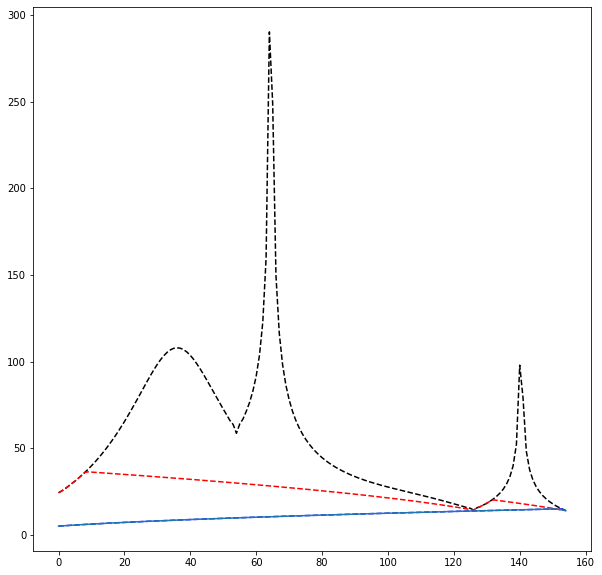

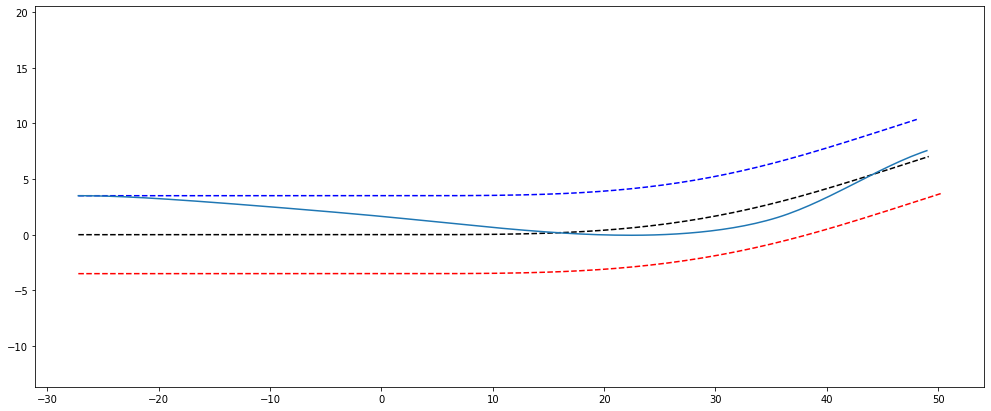

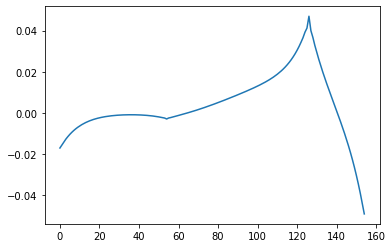

In [414]:
track=build_real_track(W=3.5,kap_max=0.01,F=path1['F'],Len=50)

real_path = build_real_path()
real_path.retrive_standard_path(F=path1['F'], P=path1['P'], path=path1['path'])
real_path.retrive_real_path(track)
real_path.get_kap()
real_path.get_velocity(V_init=5, ay_max=10.0, ax_max=1.3, ax_min=-9.5)
# 
real_path.plot()

In [325]:
for i in range(5,1,-1):
    print(i)

5
4
3
2
